# Práctica 2 - Inteligencia Artificial

### Grado Ingeniería Informática Tecnologías Informáticas

### Técnicas metaheurísticas para optimización
### Algoritmos Genéticos

Miguel A. Gutérrez Naranjo - 10 de octubre, 2022.

La Gioconda es un óleo sobre tabla de álamo de 77 × 53 cm, pintado entre 1503 y 1519 por Leonardo da Vinci. En esta práctica vamos a usar algoritmos genéticos para aproximar esa imagen mediante rectángulos en escala de grises.

<img src="gioconda.jpg">

Usaremos una representación muy básica y se espera que, tras realizar la práctica, el alumno sea capaz de probar con otros polígonos y pasar de la escala de grises a imágenes en color. También es interesante buscar otras definiciones de la función decodifica, que permite generar la imagen a partir del cromosoma, otras funciones de *fitness* y otros algoritmos genéticos. En la práctica, consideraremos poblaciones de individuos, donde cada individuo se represantará mediante una tupla de genes. Además, cada individuo tendrá asociado un determinado valor *fitness* para poder comparar entre ellos. Cada gen será una tupla $(x,y,dx,dy,c)$ que interpretaremos como un rectángulo con extremo superior izquierda $(x,y)$, lados $dx$ y $dy$ y $c\in \{0,1,\dots,255\}$ representa su color (en escala de grises).

En primer lugar cargamos las librerías que vamos a necesitar.

In [1]:
# 1.- numpy para la representación matricial
import numpy as np

# 2.- random para poder tomar valores aleatorios
import random, math

# 3.- PIL e imageio para leer y escribir imágenes.
from PIL import Image
import imageio

# Para dibujar
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['figure.figsize'] = (15,10) # Para el tamaño de la imagen

# Importamos la similaridad estructural de skimage.metrics
from skimage.metrics import structural_similarity as ssim

Para empezar, tomamos la imagen que queremos aproximar desde un fichero y lo guardamos como una imagen python (en este caso el fichero gioconda.jpg). Para ello
usamos la librería PIL para convertir la imagen en una imagen en escala de grises de 8-bits (256 valores). Ver 
https://pillow.readthedocs.io/en/3.1.x/handbook/concepts.html#concept-modes

In [2]:
imagen_original = 'gioconda.jpg'
img = Image.open(imagen_original).convert('L')

Podemos ver la imagen una vez transformada

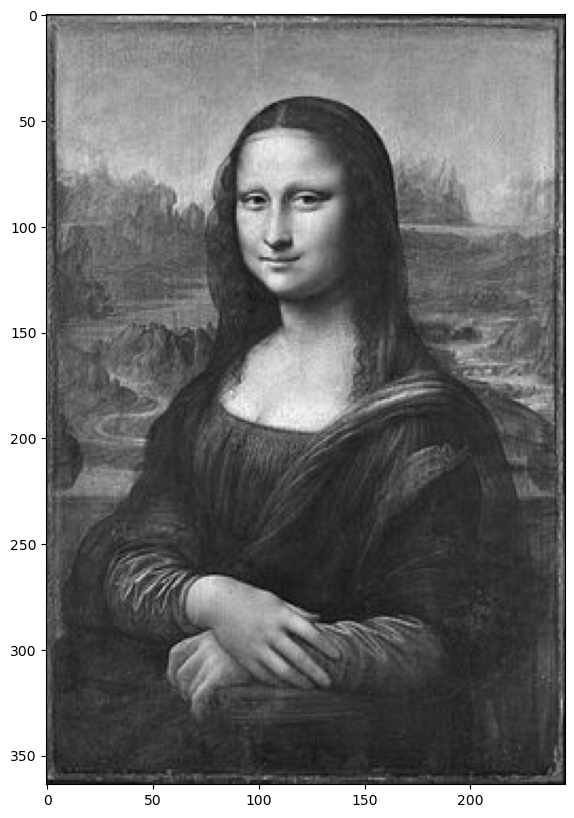

In [3]:
plt.imshow(img,cmap='gray')

A continuación, transformamos la imagen en una matriz de valores comprendido entre 0 y 255 mediante la librería numpy. Es importante saber que al cambiar el tipo de dato de imagen a matriz se cambian los ejes
https://stackoverflow.com/questions/33725237/image-fromarray-changes-size.
Llamamos IM2ARRAY a la matriz que guarda las intensidades de gris de los píxeles.

In [4]:
IM2ARRAY = np.array(img)

Podemos ver qué aspecto tiene

In [5]:
IM2ARRAY

array([[ 22,  47,  38, ...,  28,  34,  34],
       [ 87, 131,  97, ...,  26,  31,  20],
       [113, 117,  77, ...,  79,  79,  54],
       ...,
       [ 42, 102,  93, ...,  83,  77,  31],
       [ 16,  31,  17, ...,  69,  64,  31],
       [ 38,  33,  24, ...,  35,  35,  18]], dtype=uint8)

Guardamos el tamaño de la matriz en la variable *im2array_shape* para poder crear otras matrices con el mismo tamaño.

In [6]:
im2array_shape = IM2ARRAY.shape

In [7]:
im2array_shape

(364, 245)

A continuación fijamos los parámetros del algoritmo genético para aproximar la imagen original mediante rectángulos en escala de grises.

In [8]:
# Número de genes que conforman un individuo
NUMERO_DE_GENES = 150

# Tamaño de la población
TAMANO_POB = 500

# Participantes en un torneo
NUM_PARTICIPANTES = 10

# Probabilidad de mutación
PROB_MUTACION = 0.2

# Proporción de individuos que van a ser padres
PROP_CRUCES = 0.5

# Número de iteraciones
ITERACIONES = 50001

# Paso de impresión. Crearemos la imagen correspondiente al mejor individuo después de PASO_IMP iteraciones
PASO_IMP = 250

### Ejercicio 1
Define la función genera_gen() que a partir de la variable *im2array_shape* devuelva una tupla $(x,y,dx,dy,c)$. Una vez fijado el extremo $(x,y)$ dentro del lienzo, debemos tener en cuenta que el rectángulo esté dentro del lienzo y que el color esté en el rango 0-255. 

In [9]:
# Solución
def genera_gen(im2array_shape):
    x = random.randint(0, im2array_shape[0])
    y = random.randint(0, im2array_shape[1])
    dx = random.randint(0, im2array_shape[0] - x)
    dy = random.randint(0, im2array_shape[0] - y)
    c = random.randint(0, 255)

    return x, y, dx, dy, c

In [10]:
# Puedes probar la función
genera_gen(im2array_shape)

# Posible respuesta:
# (185, 223, 49, 16, 2)

(181, 230, 107, 36, 106)

### Ejercicio 2
Define genera_individuo() que devuelva una tupla con tantos genes como determine el parámetro *NUMERO_DE_GENES*

In [19]:
# Solución

def genera_individuo(NUMERO_DE_GENES, im2array_shape):
    genes = [genera_gen(im2array_shape) for _ in range(NUMERO_DE_GENES)]
    return tuple(genes)

In [40]:
# Ejemplo de uso. Guardamos el individuo generado en la variable ind_1
ind_1 = genera_individuo(20, im2array_shape)
ind_1

# Posible respuesta:
# ((53, 10, 80, 200, 114),
#  (271, 209, 6, 4, 135),
#  ...
#  (310, 220, 35, 19, 174),
#  (264, 121, 37, 45, 200))

((256, 37, 85, 44, 184),
 (9, 117, 310, 102, 65),
 (102, 110, 2, 78, 35),
 (159, 234, 159, 99, 158),
 (21, 107, 318, 0, 94),
 (101, 167, 51, 154, 210),
 (9, 204, 283, 16, 13),
 (267, 74, 94, 9, 126),
 (194, 89, 10, 157, 190),
 (99, 0, 22, 50, 18),
 (104, 148, 6, 209, 42),
 (50, 216, 180, 138, 28),
 (320, 168, 30, 126, 190),
 (127, 43, 168, 110, 156),
 (122, 147, 62, 155, 89),
 (291, 71, 47, 224, 52),
 (188, 48, 169, 40, 149),
 (74, 131, 242, 39, 146),
 (274, 9, 48, 63, 143),
 (260, 174, 59, 88, 151))

Cada gen representa un rectángulo dentro del lienzo y un individuo es una sucesión de genes. Para poder interpretar ese individuo como una imagen, primero generamos una matriz (array) a partir de ese conjunto de genes. En este caso, las posiciones que no están ocupadas por ningún cuadrado las interpretamos como blanco (valor 255) y en el resto de la posiciones se sumará la intensidad de los rectángulos que las ocupan. La función *decodifica* crea una matriz con la intensidad de gris de cada píxel a partir de un individuo.

In [41]:
# Solución:
def decodifica(ind):
    array_sal = np.zeros(im2array_shape,dtype='uint32')
    array_255 = np.full(im2array_shape,255,dtype='uint32')   
    for (x,y,dx,dy,c) in ind:
        array_sal[x:x+dx,y:y+dy]+= 255 - c
    mini = np.minimum(array_sal,array_255)
    inversa = 255 - mini
    return inversa

Podemos ver la matriz generada a partir del individuo que hemos creado.

In [42]:
matriz_1 = decodifica(ind_1)
print(matriz_1.tolist())

[[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255

Podemos ver la imagen correspondiente a ese individuo transformando la matriz en una imagen

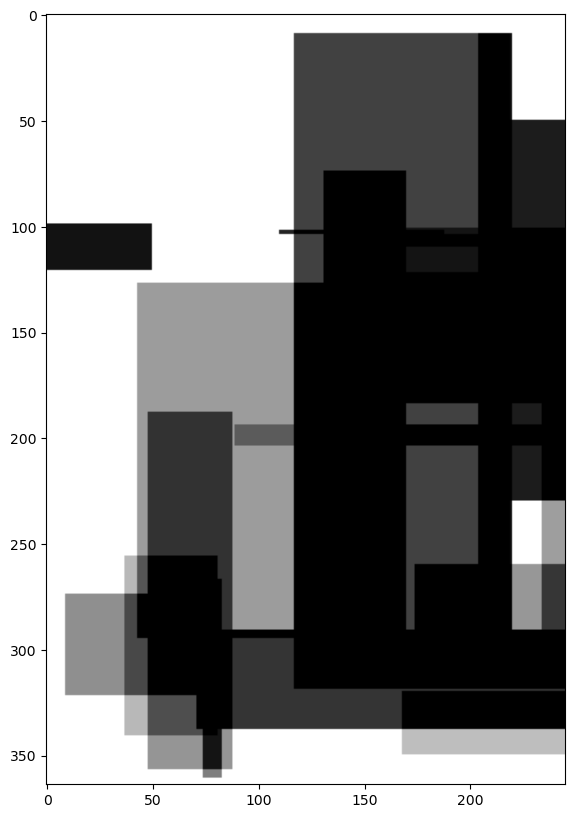

In [43]:
img_1 = Image.fromarray(matriz_1.astype('uint8'))
plt.imshow(img_1,cmap='gray')

Podemos ver una imagen junto a la otra

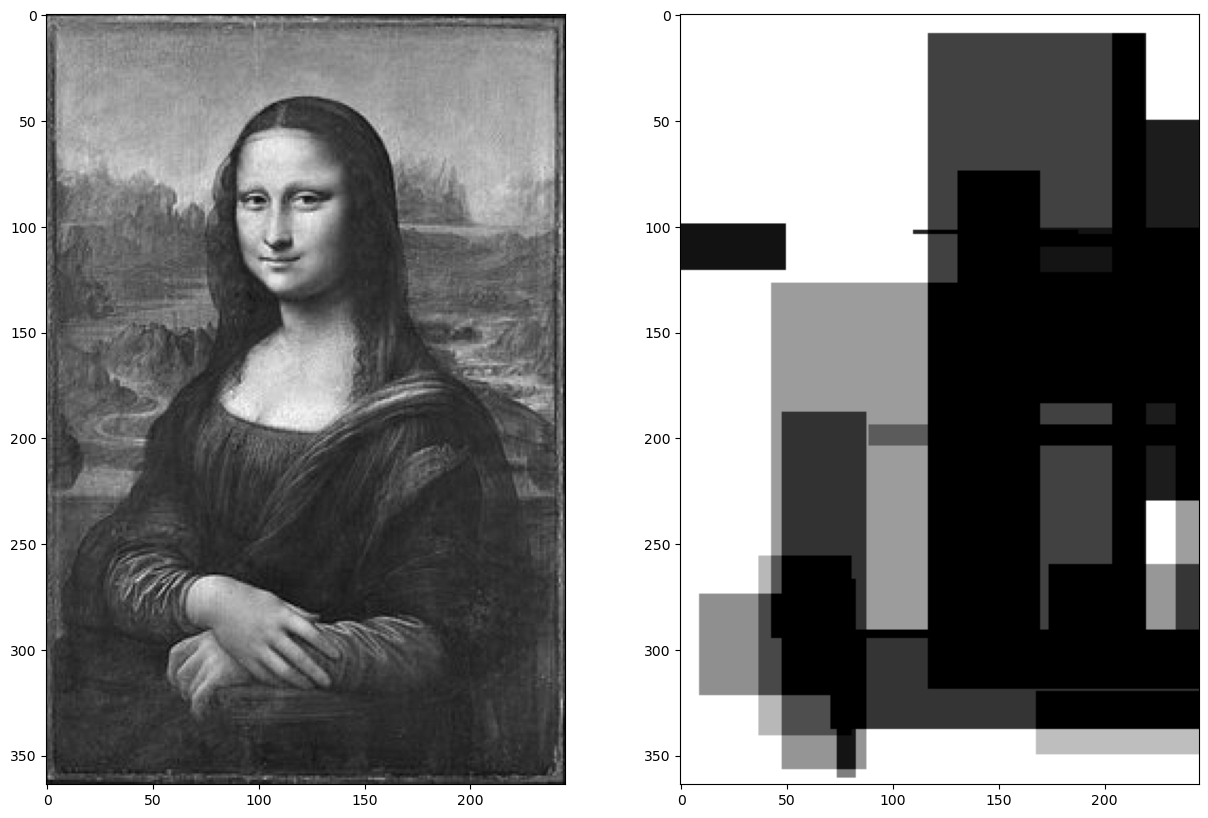

In [44]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img,cmap='gray')
axarr[1].imshow(img_1,cmap='gray')

Obviamente, este individuo es una mala aproximación de la imagen original. Vamos a implementar un algoritmo genético que permita encontrar una mejor aproximación.

Para poder lanzar el algoritmo genético, en primer lugar definimos una función que nos permita crear una población inicial de individuos.

### Ejercicio 3
Define una función poblacion_inicial() que devuelva una lista con tantos individuos como determine la variable *TAMANO_POB*

In [45]:
# Solución:

def poblacion_inicial(TAMANO_POB, NUMERO_DE_GENES, im2array_shape):
    poblacion = [genera_individuo(NUMERO_DE_GENES, im2array_shape) for _ in range(TAMANO_POB)]
    return poblacion

poblacion_inicial(3, 50, im2array_shape)

[((185, 61, 99, 267, 71),
  (137, 222, 124, 78, 229),
  (208, 193, 71, 13, 27),
  (348, 70, 11, 241, 204),
  (16, 2, 11, 216, 213),
  (112, 226, 132, 124, 15),
  (133, 39, 177, 166, 204),
  (89, 195, 12, 42, 36),
  (364, 94, 0, 256, 159),
  (51, 95, 212, 186, 189),
  (139, 45, 214, 198, 186),
  (122, 118, 147, 113, 91),
  (14, 130, 325, 14, 170),
  (151, 22, 50, 318, 25),
  (103, 92, 22, 24, 17),
  (172, 181, 20, 16, 130),
  (17, 9, 4, 272, 40),
  (158, 197, 107, 147, 254),
  (47, 70, 191, 165, 210),
  (294, 221, 23, 114, 126),
  (236, 22, 55, 167, 127),
  (324, 109, 38, 24, 7),
  (303, 151, 18, 98, 111),
  (185, 188, 148, 39, 94),
  (158, 239, 135, 5, 149),
  (127, 27, 95, 201, 46),
  (230, 106, 110, 50, 44),
  (41, 10, 29, 329, 133),
  (338, 187, 16, 144, 156),
  (204, 20, 35, 245, 159),
  (335, 139, 17, 219, 18),
  (162, 81, 160, 60, 61),
  (68, 6, 14, 320, 82),
  (322, 113, 35, 94, 125),
  (334, 69, 25, 258, 97),
  (35, 49, 232, 25, 140),
  (345, 190, 7, 81, 223),
  (314, 33, 29, 2

Para poder seleccionar los mejores inidividuos de la población, necesitamos definir una función fitness. En este caso la función fitness se define como la suma de las diferencias (en valor absoluto) pixel a pixel entre la matriz que representa el individuo y la matriz que representa la imagen original.

In [46]:
def fitness_1(ind):
    return np.sum(np.absolute(decodifica(ind) - IM2ARRAY))

In [47]:
# Ejemplo:
fitness_1(ind_1)

184954179662008

A continuación implementamos la selección por torneo. Para evitar repetir cálculos, cuando calculemos la función fitness de un individuo, la guardaremos en un diccionario y miraremos si ya ha sido calculada antes cuando necesitemos saber su valor. Las claves del diccionario serán los individuos y su valor, el valor de la función *fitness* que le corresponda.

### Ejercicio 4
Define la función *selecciona_uno_por_torneo(poblacion,dic)* que tome como entrada una población de individuos y un diccionario de pares *individuo:fitness* y devuelva una tupla *(seleccionado,nuevo_dic)* donde seleccionado sea un individuo de la población seleccionado por torneo con *NUM_PARTICIPANTES* como el número de participantes en cada torneo y *nuevo_dic* sea el diccionario *dic* al que se le han añadido los pares *individuo:fitness* que se hayan calculado en la búsqueda de *seleccionado*.

In [128]:
# Solución:

NUM_PARTICIPANTES = 4

def selecciona_uno_por_torneo(poblacion, dic):
    #num_participantes = random.randint(1, len(poblacion))
    participantes = random.sample(poblacion, NUM_PARTICIPANTES)
    nuevo_dic = dic.copy()
    max_cand = participantes[0]
    for ind in participantes:
        if not ind in nuevo_dic:
            nuevo_dic[ind] = fitness_1(ind)
        if nuevo_dic[ind] > nuevo_dic[max_cand]:
            max_cand = ind

    return max_cand, nuevo_dic 
    

In [129]:
# Ejemplo de uso
# selecciona_uno_por_torneo(poblacion_inicial(),{},fitness_1)
# participantes = [random.choice(poblacion_inicial(3, 50, im2array_shape)) for _ in range(3)]

selecciona_uno_por_torneo(poblacion_inicial(7, 50, im2array_shape),{})


(((277, 182, 50, 74, 68),
  (352, 13, 4, 283, 4),
  (308, 240, 7, 83, 155),
  (329, 10, 1, 37, 43),
  (163, 79, 146, 28, 115),
  (73, 10, 125, 353, 118),
  (198, 126, 6, 231, 207),
  (212, 57, 143, 260, 167),
  (168, 165, 10, 104, 187),
  (328, 60, 16, 232, 146),
  (257, 37, 57, 271, 237),
  (81, 130, 249, 136, 97),
  (224, 221, 64, 143, 144),
  (58, 147, 80, 33, 61),
  (212, 179, 49, 6, 20),
  (177, 65, 76, 277, 18),
  (139, 140, 199, 105, 8),
  (151, 238, 39, 79, 183),
  (184, 103, 118, 133, 169),
  (80, 62, 185, 18, 82),
  (10, 67, 120, 81, 12),
  (141, 166, 173, 113, 77),
  (291, 35, 40, 123, 221),
  (137, 219, 150, 17, 79),
  (180, 59, 167, 293, 138),
  (173, 117, 38, 38, 209),
  (206, 185, 92, 99, 26),
  (111, 148, 199, 210, 172),
  (103, 104, 21, 84, 191),
  (175, 58, 63, 284, 208),
  (161, 151, 65, 138, 140),
  (201, 203, 122, 98, 243),
  (171, 26, 39, 123, 121),
  (354, 66, 0, 22, 62),
  (162, 196, 190, 28, 166),
  (59, 163, 177, 164, 106),
  (129, 28, 25, 1, 205),
  (152, 24,

### Ejercicio 5
Define la función *seleccion_por_torneo(poblacion,num_seleccionados,dic)* que además de la población y el diccionario del ejercicio anterior toem el número de individuos que queremos seleccionar. La salida debe ser una tupla *(seleccion,nuevo_dic)* donde *nuevo_dic* es el diccionario actualizado y sleccion una lista de individuos seleccionados. 

In [132]:
# Solución:

def seleccion_por_torneo(poblacion, num_seleccionados, dic):
    nuevo_dic = dic.copy()
    seleccion = []
    
    for _ in range(num_seleccionados):
        sel_torneo = selecciona_uno_por_torneo(poblacion, nuevo_dic)

        nuevo_dic = sel_torneo[1]
            
        seleccion.append(sel_torneo[0])

    return seleccion, nuevo_dic

In [133]:
# Ejemplo de uso
seleccion_por_torneo(poblacion_inicial(7, 50, im2array_shape),4,{})

([((139, 25, 225, 88, 188),
   (241, 22, 104, 109, 251),
   (70, 222, 117, 14, 97),
   (19, 6, 226, 114, 0),
   (214, 29, 50, 109, 32),
   (62, 211, 71, 6, 34),
   (291, 146, 72, 115, 85),
   (191, 125, 84, 69, 48),
   (143, 203, 140, 150, 160),
   (8, 163, 296, 170, 165),
   (104, 224, 138, 31, 28),
   (259, 212, 18, 31, 25),
   (230, 244, 49, 105, 183),
   (42, 108, 241, 44, 59),
   (225, 158, 47, 121, 38),
   (220, 76, 30, 153, 144),
   (363, 168, 0, 28, 21),
   (266, 218, 63, 28, 68),
   (195, 235, 58, 112, 90),
   (162, 140, 29, 223, 237),
   (120, 235, 168, 115, 222),
   (66, 205, 116, 51, 217),
   (113, 144, 206, 116, 241),
   (314, 152, 34, 17, 246),
   (243, 147, 47, 23, 227),
   (89, 26, 197, 42, 128),
   (217, 118, 72, 245, 26),
   (15, 79, 173, 162, 158),
   (263, 26, 94, 218, 99),
   (25, 175, 114, 154, 168),
   (13, 34, 55, 73, 10),
   (37, 42, 26, 215, 150),
   (116, 159, 177, 93, 207),
   (179, 222, 97, 127, 33),
   (151, 8, 196, 348, 179),
   (264, 11, 24, 34, 170),
  

A continuación definimos el cruce entre individuos

### Ejercicio 6
Define la función *cruza(i1,i2)* que tome dos individuos y devuelva una lista con los dos hijos obtenidos mediante la técnica de cruce en un punto.

In [146]:
# Solución:


def cruza(i1, i2):
    pos = random.randrange(1, len(i1)-1)
    hijo1 = i1[:pos] + i2[pos:]
    hijo2 = i1[pos:] + i2[:pos]
    return [hijo1, hijo2]


i1 = genera_individuo(20, im2array_shape)
i2 = genera_individuo(20, im2array_shape)

cruza(i1, i2)

[((197, 158, 98, 200, 82),
  (122, 115, 147, 141, 146),
  (3, 83, 190, 91, 17),
  (347, 114, 6, 44, 208),
  (282, 54, 24, 289, 44),
  (339, 114, 10, 74, 109),
  (275, 74, 31, 283, 19),
  (9, 128, 50, 220, 123),
  (199, 213, 121, 99, 50),
  (309, 80, 4, 161, 214),
  (119, 206, 134, 113, 113),
  (237, 154, 69, 117, 196),
  (266, 97, 21, 127, 155),
  (36, 100, 301, 174, 108),
  (144, 218, 124, 8, 102),
  (165, 102, 60, 16, 79),
  (94, 196, 30, 57, 143),
  (62, 218, 219, 137, 76),
  (100, 150, 249, 107, 155),
  (276, 44, 64, 245, 73)),
 ((236, 132, 94, 138, 175),
  (355, 209, 6, 103, 130),
  (358, 162, 3, 195, 210),
  (271, 211, 17, 99, 162),
  (303, 241, 32, 58, 214),
  (292, 98, 51, 44, 56),
  (88, 199, 15, 63, 203),
  (234, 157, 101, 114, 27),
  (145, 154, 90, 181, 26),
  (79, 22, 121, 213, 36),
  (284, 5, 6, 118, 51),
  (162, 111, 164, 4, 248),
  (0, 238, 214, 8, 13),
  (359, 115, 1, 13, 188),
  (43, 24, 24, 24, 73),
  (103, 123, 18, 42, 3),
  (342, 228, 5, 136, 178),
  (98, 16, 262, 1

### Ejercicio 7
Define la función *cruza_padres(padres)* que tome como entrada la lista *padres* con un número par de individuos y devuelva la lista de individuos obtenida aplicando la función *cruza(i1,i2)* donde *i1* es un individuo que ocupa una posición de índice par e *i2* es el siguiente individuo.

In [148]:
# Solución:

def cruza_padres(padres):
    hijos = []
    for j in range(0, len(padres), 2):
        hijos.extend(cruza(padres[j], padres[j+2]))
    return hijos

En esta práctica consideraremos que la mutación de un individuo consiste en sustituir uno de sus genes por otro elegido aleatoriamente.

### Ejercicio 8
Define la función *muta(ind)* que reciba como entrada un individuo *ind* y que, con una probabilidad *PROB_MUTACION* cambie uno de sus genes por otro gen aleatorio.

In [ ]:
# Solución:


### Ejercicio 9
Define una función *muta_individuos(poblacion)* que reciba como entrada a lista de individuos *poblacion* y aplique la función *muta* a cada uno de los individuos.

In [ ]:
# Solución:


A continuación definimos el algoritmo que permite encontrar una nueva generación a partir de una dada.

### Ejercicio 10
Define una función *nueva_generacion(poblacion,n_padres,n_directos,dic)* que reciba como entrada:
* *poblacion* es una población de individuos
* *n_padres* es un número que determina cuántos individuos seleccionamos por torneo para ser padres
* *n_directos* es un número que determina cuántos individuos seleccionamos por torneo para pasar directamente a la siguiente generación.
* dic es un diccionario de pares individuo:fitness

La función debe seleccionar un conjunto de individuos para ser padres y otro para pasar directamente a la siguiente generación y a partir de los padres se debe genera un conjunto de hijos por cruce. La función debe devolver una tupla *(nuevo_dic,nueva_pob)* donde *nueva_pob* es una lista de individuos formada por los individuos que han pasado directamente a la siguiente generación más el resultado de aplicar la función de mutación a los hijos.

In [ ]:
# Solución:


Por último definimos el algoritmo genetico en el que se genera un a población inicial y se van creando nuevas generaciones usando las funciones anteriores. Además, cada *PASO_IMP* imprimimos la imagen correspondiente al mejor individuo. La función devuelve la lista de los valores *fitnes*  de estos individuos para poder luego representar gráficamente la evolución de la función a lo largo de las iteraciones.

In [ ]:
# ga_{:>08}.jpg rellena hasta 8 posiciones con 0 por la izquierda 

In [ ]:
# Solución:
def algoritmo_genetico():
    poblacion= poblacion_inicial()
    dic = {}
    n_padres = round(TAMANO_POB * PROP_CRUCES)
    n_padres = (n_padres if n_padres%2==0 else n_padres-1)
    n_directos = TAMANO_POB - n_padres
    mejores = []
    for counter in range(ITERACIONES):
        if counter%PASO_IMP == 0:
            print(counter)
            nuevo_dic = {}
            actual = 'inicial'
            min = float('inf')
            for ind in poblacion:
                f_ind = fitness(ind)
                nuevo_dic[ind] = f_ind
                if f_ind < min:
                    actual = ind
                    min = f_ind
            img_mejor = decodifica(actual).astype('uint8')
            imageio.imwrite('ga_{:>08}.jpg'.format(counter//PASO_IMP),img_mejor)
            mejores.append(min)
            dic, poblacion = nueva_generacion(poblacion,n_padres,n_directos,dic)
        else:
            dic, poblacion = nueva_generacion(poblacion,n_padres,n_directos,dic)
            print('.',end='')
    return mejores


In [ ]:
# sal_ag_1 = algoritmo_genetico(fitness_1)

In [ ]:
# plt.plot(sal_ag_1[1:])
# plt.show()

### Ejercicio 11
La función fitness definida anteriormente es fácil de implementar, pero no es la más apropiada para comparar imágenes. Vamos a considerar otra medida basada en la similaridad estructural para comparar imágenes

In [ ]:
def fitness_2(ind):
    dec = decodifica(ind)
    return 1 - ssim(IM2ARRAY, dec, data_range=dec.max() - dec.min())

In [ ]:
# Ejemplo:
fitness_2(ind_1)

In [ ]:
sal_ag_2 = algoritmo_genetico(fitness_2)

In [ ]:
plt.plot(sal_ag_2[1:])
plt.show()